# BNN using MCMC for predicting Band Gaps 

In [3]:
from pyro.infer import MCMC, NUTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from BNN_model import BayesianNN

from sklearn.preprocessing import StandardScaler
import torch.distributions as dist

# Use predictive distribution
from pyro.infer import Predictive


### Read the data 

In [4]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/mp_data_100k_cleaned2.csv')

In [5]:
df_mp.head()

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
0,0,99994,10,Sr1 Cr1 H1 O2,SrCrHO2,116.010397,"{'crystal_system': 'Tetragonal', 'symbol': 'P4...",mp-1218324,"{'@module': 'pymatgen.core.structure', '@class...",-2.090215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,28876,12,Sc1 I1 O1,ScIO,279.252151,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-559760,"{'@module': 'pymatgen.core.structure', '@class...",-2.891759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,41418,40,Ga3 Bi5 Cl12,Ga3Bi5Cl12,1302.857133,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-569854,"{'@module': 'pymatgen.core.structure', '@class...",-1.229581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,41414,10,Ag1 N1 O3,AgNO3,125.104504,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-552185,"{'@module': 'pymatgen.core.structure', '@class...",-0.680664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,28883,24,Tl1 Cr3 O8,TlCr3O8,361.671041,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-561221,"{'@module': 'pymatgen.core.structure', '@class...",-1.778230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

### Train-test split

In [7]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

#print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

In [8]:
#visualize the distrubution of  the band gap data 
"""
plt.hist(y, bins=50)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of Band Gap Values')
plt.show()

#visualise the bannd gap vs index 
plt.scatter(range(len(y)), y, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Band Gap vs Index')
plt.show()
"""

"\nplt.hist(y, bins=50)\nplt.xlabel('Band Gap (eV)')\nplt.ylabel('Frequency')\nplt.title('Distribution of Band Gap Values')\nplt.show()\n\n#visualise the bannd gap vs index \nplt.scatter(range(len(y)), y, alpha=0.5)\nplt.xlabel('Index')\nplt.ylabel('Band Gap (eV)')\nplt.title('Band Gap vs Index')\nplt.show()\n"

In [9]:
"""
#visualise sorted band gap values
sorted_y = np.sort(y)
plt.plot(sorted_y[: : 10], marker='o', markersize=3, linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Sorted Band Gap Values')
plt.show()
"""

"\n#visualise sorted band gap values\nsorted_y = np.sort(y)\nplt.plot(sorted_y[: : 10], marker='o', markersize=3, linestyle='-', color='blue', alpha=0.7)\nplt.xlabel('Index')\nplt.ylabel('Band Gap (eV)')\nplt.title('Sorted Band Gap Values')\nplt.show()\n"

In [10]:
#Log transformed distribution: 
epsilon = 1e-3 #to avoid dividing by zero 
y_log = np.log(y + epsilon)

""" 
# Plot histogram of log-transformed band gap values
plt.figure(figsize=(7, 5))
plt.hist(y_log, bins=50, color='blue', edgecolor='black')
plt.xlabel('log₁₀(Band Gap + ε) [eV]')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Band Gap Values')
plt.grid(True)
plt.tight_layout()
plt.show()
"""

" \n# Plot histogram of log-transformed band gap values\nplt.figure(figsize=(7, 5))\nplt.hist(y_log, bins=50, color='blue', edgecolor='black')\nplt.xlabel('log₁₀(Band Gap + ε) [eV]')\nplt.ylabel('Frequency')\nplt.title('Log-Transformed Distribution of Band Gap Values')\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n"

### Data preprocessing

In [11]:

# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element'
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])

# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)
X_raw = X_raw.fillna(0)

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)


#y_train_log = np.log(y_train_raw)
#y_test_log = np.log(y_test_raw)

In [12]:
#print(y_train_log)

In [13]:
# Normalise training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data


y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

# Store the selector
#selector = SelectKBest(score_func=f_regression, k=100)
#X_train_selected = selector.fit_transform(X_train, y_train)



#mask = selector.get_support()                # boolean mask of selected features
#selected_indices = selector.get_support(indices=True)  # or integer indices

#selected_feature_names = X_train_raw.columns[mask].tolist()
#print(selected_feature_names)


# Convert to Pytorch tensors
#C onverts the NumPy arrays into torch.tensor objects, which are the format needed for training/testing the BNN in PyTorch.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [14]:
#print(len(X_train), len(X_test))

### MCMC Sample and run the model 

In [15]:
model = BayesianNN(input_dim=X_train.shape[1])  # Initialise BayesianNN model

nuts_kernel = NUTS(model)  # No-U-Turn Sampler — a smart version of Hamiltonian Monte Carlo (HMC) that avoids manually setting path lengths
#=> performs gradient-based MCMC to sample from the posterior distribution over the model parameters, given data.

#Run MCMC 
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=200)
mcmc.run(X_train_tensor, y_train_tensor) #After: 300 samples from the posterior distribution over the weights and biases of the BNN

posterior_samples = mcmc.get_samples() # dictionary of sampled model parameters (e.g., weights, biases)


Warmup:   0%|          | 0/500 [00:00, ?it/s]

Sample: 100%|██████████| 500/500 [7:50:50, 56.50s/it, step size=1.27e-03, acc. prob=0.811] 


### Make predictions 

In [16]:
""" 

# === Predictive distribution from posterior samples ===
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# === Get predictive mean and std in standardized log space ===
mean_pred = preds.mean(dim=0).numpy()  # [num_test_points]
std_pred = preds.std(dim=0).numpy()

# === Inverse-transform: standardized log → log → actual band gap ===

# Step 1: unstandardize the mean (i.e., bring it back to log space)
mean_pred_log = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

# Step 2: exponentiate to return to original band gap values (eV)
mean_pred_actual = np.exp(mean_pred_log)

# === Adjust uncertainty: transform std back to original units (approximation) ===

# Step 1: unstandardize std — std transforms linearly under scaling
std_pred_log = std_pred * scaler_y.scale_[0]

# Step 2: approximate std in original scale using delta method:
# Var(Y) ≈ (d/dx exp(x))^2 * Var(X) = (exp(mean))^2 * Var(X)
std_pred_actual = mean_pred_actual * std_pred_log  # because d/dx exp(x) = exp(x)

# === Inverse-transform true y values for evaluation/plotting ===
y_test_log = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_actual = np.exp(y_test_log)

# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()
"""



' \n\n# === Predictive distribution from posterior samples ===\npredictive = Predictive(model, posterior_samples, return_sites=["obs"])\npreds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]\n\n# === Get predictive mean and std in standardized log space ===\nmean_pred = preds.mean(dim=0).numpy()  # [num_test_points]\nstd_pred = preds.std(dim=0).numpy()\n\n# === Inverse-transform: standardized log → log → actual band gap ===\n\n# Step 1: unstandardize the mean (i.e., bring it back to log space)\nmean_pred_log = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()\n\n# Step 2: exponentiate to return to original band gap values (eV)\nmean_pred_actual = np.exp(mean_pred_log)\n\n# === Adjust uncertainty: transform std back to original units (approximation) ===\n\n# Step 1: unstandardize std — std transforms linearly under scaling\nstd_pred_log = std_pred * scaler_y.scale_[0]\n\n# Step 2: approximate std in original scale using delta method:\n# Var(Y) ≈ (d

In [17]:
 """
#=== Plot: Predicted vs Actual in Log-Transformed Space ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, mean_pred_log, alpha=0.7, label="Predictions")
plt.plot([y_test_log.min(), y_test_log.max()],
         [y_test_log.min(), y_test_log.max()],
         'r--', label="Ideal")  # 45-degree line
plt.xlabel("True log(Band Gap)")
plt.ylabel("Predicted log(Band Gap)")
plt.title("Predicted vs Actual (Log-Transformed Space)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""


'\n#=== Plot: Predicted vs Actual in Log-Transformed Space ===\nplt.figure(figsize=(6, 6))\nplt.scatter(y_test_log, mean_pred_log, alpha=0.7, label="Predictions")\nplt.plot([y_test_log.min(), y_test_log.max()],\n        [y_test_log.min(), y_test_log.max()],\n        \'r--\', label="Ideal")  # 45-degree line\nplt.xlabel("True log(Band Gap)")\nplt.ylabel("Predicted log(Band Gap)")\nplt.title("Predicted vs Actual (Log-Transformed Space)")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [18]:

#getting predictions from the posterior 
predictive = Predictive(model, posterior_samples, return_sites=["obs"]) #Predictive in Pyro uses sample from posterior to generate predictiosn 
#=> return predictions at the "obs" site in the model, which corresponds to the observed outputs (e.g., target band gaps).

#pass X_test_tensor (test inputs as a PyTorch tensor) to the predictive object.
#=> Each row in preds corresponds to predictions from one set of posterior parameters.
preds = predictive(X_test_tensor)["obs"]  # output shape: [num_samples, num_test_points]

mean_pred = preds.mean(dim=0).numpy() #average over the posterior predictive samples — predictive mean, best estimate of the output
std_pred = preds.std(dim=0).numpy() # standard deviation over the predictive samples — epistemic uncertainty

# Inverse-transform band gaps
#converts the predicted means back to the original scale (eV) from being scaled using StandardScaler
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

#adjust the predicted uncertainty to match the units of the original data.
std_pred_actual = std_pred * scaler_y.scale_[0]  # std scales linearly

#convert the standardized y_test targets back to the original scale, for comparison with predictions.
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()#

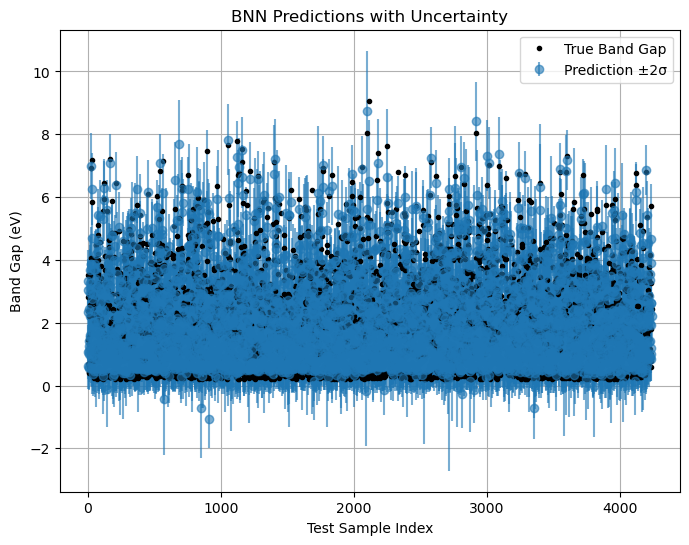

In [19]:

plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

#### Compute log-likelihood

For original data: 

Total Log-Likelihood (Test): -1897.12
Average Log-Likelihood per Sample: -0.4477
Negative Log-Likelihood (NLL): 1897.12
Average NLL per Sample: 0.4477


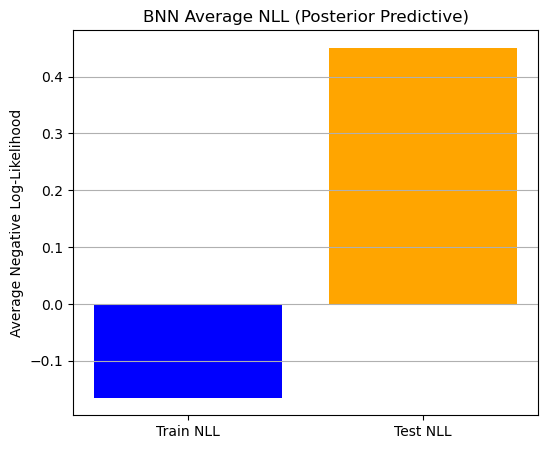

Average Train NLL: -0.1648
Average Test NLL: 0.4505


In [20]:

test_preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# Mean and std from posterior predictive samples
mean_pred = test_preds.mean(dim=0)
std_pred = test_preds.std(dim=0) + 1e-6  # avoid log(0)

# Assume Gaussian predictive distribution
likelihood = dist.Normal(mean_pred, std_pred)

# Convert true y_test values (already standardized) to tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Compute log-probability of true values under the predictive distribution
log_probs = likelihood.log_prob(y_test_tensor)  # shape: [num_test_points]

# Compute total and average log-likelihood
log_likelihood_total = log_probs.sum().item()
log_likelihood_avg = log_probs.mean().item()
nll = -log_likelihood_total
nll_avg = -log_likelihood_avg

print(f"Total Log-Likelihood (Test): {log_likelihood_total:.2f}")
print(f"Average Log-Likelihood per Sample: {log_likelihood_avg:.4f}")
print(f"Negative Log-Likelihood (NLL): {nll:.2f}")
print(f"Average NLL per Sample: {nll_avg:.4f}")

#Get all posterior predictive samples for train and test
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
train_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]
test_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]

# Compute mean and std for each data point across posterior samples
train_mean = train_preds.mean(dim=0)
train_std = train_preds.std(dim=0) + 1e-6
test_mean = test_preds.mean(dim=0)
test_std = test_preds.std(dim=0) + 1e-6

# Compute NLL for each data point
train_likelihood = dist.Normal(train_mean, train_std)
test_likelihood = dist.Normal(test_mean, test_std)

# Ensure targets are tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Log-probabilities for each data point
train_log_probs = train_likelihood.log_prob(y_train_tensor)
test_log_probs = test_likelihood.log_prob(y_test_tensor)

# Average NLL
train_nll = -train_log_probs.mean().item()
test_nll = -test_log_probs.mean().item()

# Plot
plt.figure(figsize=(6, 5))
plt.bar(['Train NLL', 'Test NLL'], [train_nll, test_nll], color=['blue', 'orange'])
plt.ylabel("Average Negative Log-Likelihood")
plt.title("BNN Average NLL (Posterior Predictive)")
plt.grid(axis='y')
plt.show()

print(f"Average Train NLL: {train_nll:.4f}")
print(f"Average Test NLL: {test_nll:.4f}")

In [21]:
mean_pred = preds.mean(dim=0).numpy()  # predictive mean
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
#y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

from sklearn.metrics import r2_score
r2 = r2_score(y_test_actual, mean_pred_actual)
print("R² score:", r2)

R² score: 0.8233925872274387


In [22]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, mean_pred_actual)

# Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, mean_pred_actual)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test_actual, mean_pred_actual) * 100  # in %

# Display
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


R² Score: 0.8234
Mean Squared Error (MSE): 0.3863
Root Mean Squared Error (RMSE): 0.6215
Mean Absolute Error (MAE): 0.4315
Mean Absolute Percentage Error (MAPE): 44.77%


For log-transformed data 

In [23]:
"""

# Ensure targets are tensors (in standardized log space)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Get all posterior predictive samples for train and test
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
train_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]
test_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]

# Compute mean and std for each point across posterior samples
train_mean = train_preds.mean(dim=0)
train_std = train_preds.std(dim=0).clamp(min=1e-6)  # avoid numerical issues
test_mean = test_preds.mean(dim=0)
test_std = test_preds.std(dim=0).clamp(min=1e-6)

# Predictive Normal distributions
train_likelihood = dist.Normal(train_mean, train_std)
test_likelihood = dist.Normal(test_mean, test_std)

# Log-probabilities for each data point
train_log_probs = train_likelihood.log_prob(y_train_tensor)
test_log_probs = test_likelihood.log_prob(y_test_tensor)

# === Compute NLL
train_nll = -train_log_probs.mean().item()
test_nll = -test_log_probs.mean().item()

# Total log-likelihoods (optional)
total_train_ll = train_log_probs.sum().item()
total_test_ll = test_log_probs.sum().item()

# === Print results
print(f"Average Train NLL: {train_nll:.4f}")
print(f"Average Test NLL: {test_nll:.4f}")
print(f"Total Train Log-Likelihood: {total_train_ll:.2f}")
print(f"Total Test Log-Likelihood: {total_test_ll:.2f}")

# === Plot NLL comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.bar(['Train NLL', 'Test NLL'], [train_nll, test_nll], color=['blue', 'orange'])
plt.ylabel("Average Negative Log-Likelihood")
plt.title("BNN Average NLL (Posterior Predictive)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
"""


'\n\n# Ensure targets are tensors (in standardized log space)\ny_train_tensor = torch.tensor(y_train, dtype=torch.float32)\ny_test_tensor = torch.tensor(y_test, dtype=torch.float32)\n\n# Get all posterior predictive samples for train and test\npredictive = Predictive(model, posterior_samples, return_sites=["obs"])\ntrain_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]\ntest_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]\n\n# Compute mean and std for each point across posterior samples\ntrain_mean = train_preds.mean(dim=0)\ntrain_std = train_preds.std(dim=0).clamp(min=1e-6)  # avoid numerical issues\ntest_mean = test_preds.mean(dim=0)\ntest_std = test_preds.std(dim=0).clamp(min=1e-6)\n\n# Predictive Normal distributions\ntrain_likelihood = dist.Normal(train_mean, train_std)\ntest_likelihood = dist.Normal(test_mean, test_std)\n\n# Log-probabilities for each data point\ntrain_log_probs = train_likelihood.log_prob(y_t

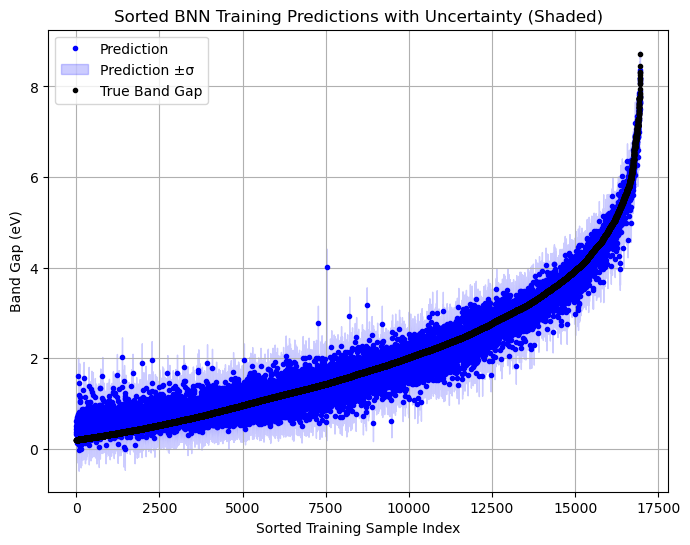

In [24]:

# Get posterior predictions on training data
preds_train = predictive(X_train_tensor)["obs"]
mean_pred_train = preds_train.mean(dim=0).numpy()
std_pred_train = preds_train.std(dim=0).numpy()

# Inverse-transform
mean_pred_train_actual = scaler_y.inverse_transform(mean_pred_train.reshape(-1, 1)).ravel()
std_pred_train_actual = std_pred_train * scaler_y.scale_[0]
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Sort by true values for plotting
sorted_indices = np.argsort(y_train_actual)
sorted_mean_pred_actual = mean_pred_train_actual[sorted_indices]
sorted_std_pred_actual = std_pred_train_actual[sorted_indices]
sorted_y_train_actual = y_train_actual[sorted_indices]

# Compute bounds for uncertainty region (±1σ or use ±2σ if preferred)
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual
"""
"""
# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_train_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Training Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Training Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
#plt.show()


In [25]:
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]
"""
# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(sorted_mean_pred_actual)), sorted_mean_pred_actual, yerr=2*sorted_std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(sorted_y_test_actual)), sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()
"""

'\n# Plot with confidence interval\nplt.figure(figsize=(8, 6))\nplt.errorbar(np.arange(len(sorted_mean_pred_actual)), sorted_mean_pred_actual, yerr=2*sorted_std_pred_actual, fmt=\'o\', label="Prediction ±2σ", alpha=0.6)\nplt.plot(np.arange(len(sorted_y_test_actual)), sorted_y_test_actual, \'k.\', label="True Band Gap")\nplt.xlabel("Test Sample Index")\nplt.ylabel("Band Gap (eV)")\nplt.title("BNN Predictions with Uncertainty")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

In [26]:
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual
"""
plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()
"""

'\nplt.figure(figsize=(8, 6))\nplt.plot(x, sorted_mean_pred_actual, \'b.\', label="Prediction")\nplt.fill_between(x, lower, upper, color=\'blue\', alpha=0.2, label="Prediction ±σ")\nplt.plot(x, sorted_y_test_actual, \'k.\', label="True Band Gap")\nplt.xlabel("Sorted Test Sample Index")\nplt.ylabel("Band Gap (eV)")\nplt.title("Sorted BNN Predictions with Uncertainty (Shaded)")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

In [27]:
#get information about outliers 
outliers = np.abs(sorted_mean_pred_actual - sorted_y_test_actual) > 1.5 # Define outliers as those with a difference greater than 0.2 eV
outlier_indices = np.where(outliers)[0]
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
"""
print("Outlier Indices:", outlier_indices)
print("Outlier Predictions:", sorted_mean_pred_actual[outlier_indices])
print("Outlier True Values:", sorted_y_test_actual[outlier_indices])
"""

'\nprint("Outlier Indices:", outlier_indices)\nprint("Outlier Predictions:", sorted_mean_pred_actual[outlier_indices])\nprint("Outlier True Values:", sorted_y_test_actual[outlier_indices])\n'

In [28]:
outlier_test_indices = sorted_indices[outlier_indices]

In [29]:
# Map test index to original DataFrame index
outlier_original_indices = idx_test[outlier_test_indices]


#### Plot shading ±1 standard deviation (σ) (68% confidence)

In [30]:
# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get pretty formulas from original dataset
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# Plot predictions and uncertainty
x = np.arange(len(sorted_mean_pred_actual))
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]
"""
plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate each outlier with formula and predicted band gap
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )
# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions from log-transformed data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

"""

'\nplt.figure(figsize=(10, 6))\nplt.plot(x, sorted_mean_pred_actual, \'b.\', label="Prediction")\nplt.fill_between(x, lower, upper, color=\'blue\', alpha=0.2, label="Prediction ±σ")\nplt.plot(x, sorted_y_test_actual, \'k.\', label="True Band Gap")\nplt.scatter(x[outlier_indices], outlier_preds, color=\'red\', edgecolor=\'black\', s=80, label=\'Outliers\')\n\n# Annotate each outlier with formula and predicted band gap\nfor i, idx in enumerate(outlier_indices):\n    pred_val = sorted_mean_pred_actual[idx]\n    formula = formulas[i]\n    plt.annotate(\n        f"{formula}\n{pred_val:.2f} eV",\n        (x[idx], pred_val),\n        textcoords="offset points",\n        xytext=(0, 10),\n        ha=\'center\',\n        fontsize=8,\n        color=\'darkred\'\n    )\n# Formatting\nplt.xlabel("Sorted Test Sample Index")\nplt.ylabel("Band Gap (eV)")\nplt.title("BNN Predictions from log-transformed data")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\n'

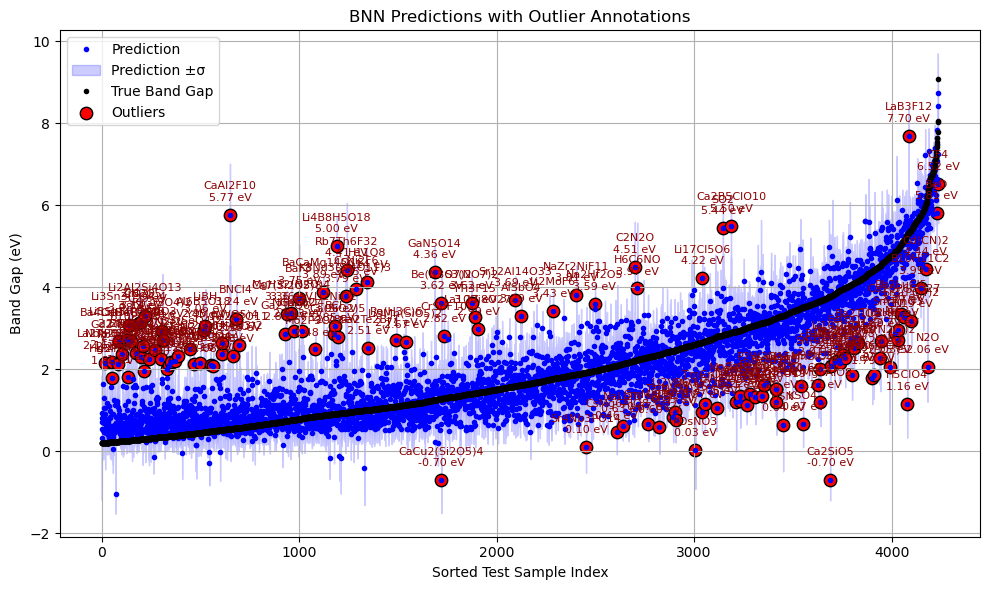

In [31]:
# Sort both arrays using the same indices
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]

# Now you can safely subtract
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # > 1.5 eV difference is considered an outlier
outlier_indices = np.where(outlier_mask)[0]  # indices in the sorted array
outlier_preds = sorted_mean_pred_actual[outlier_indices]

# === Map sorted test indices → original dataset row indices ===
outlier_test_indices = sorted_indices[outlier_indices]           # in X_test
outlier_original_indices = idx_test[outlier_test_indices]        # in df_mp

# === Retrieve formulas using original indices ===
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# === Plot predictions with uncertainty and annotate outliers ===
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate outliers
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# === Plot formatting ===
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Outlier Annotations")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.savefig('BNN_MCMC_Basic_model.png', dpi=300)


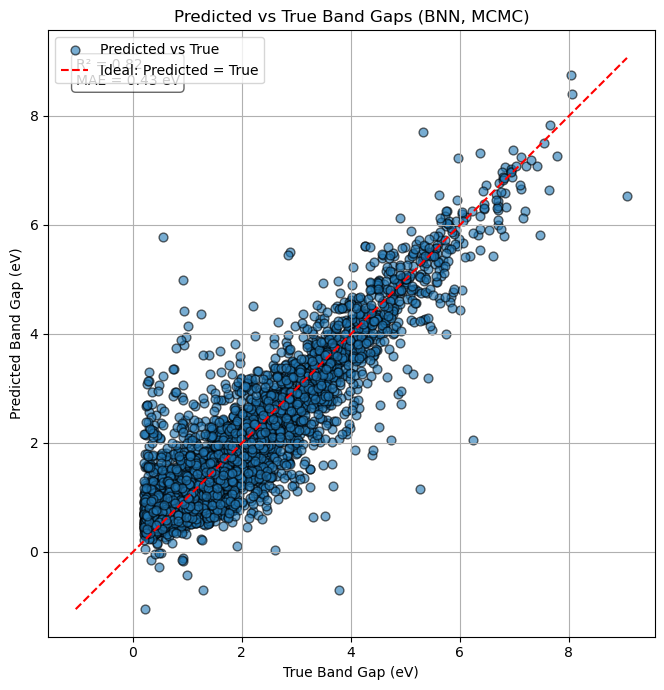

In [32]:
# mean_pred_actual: predicted mean band gaps (already inverse-transformed to eV)
# y_test_actual: true band gaps (already inverse-transformed to eV)

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate stats
r2 = r2_score(y_test_actual, mean_pred_actual)
mae = mean_absolute_error(y_test_actual, mean_pred_actual)

# Determine axis limits with padding
min_val = min(y_test_actual.min(), mean_pred_actual.min())
max_val = max(y_test_actual.max(), mean_pred_actual.max())
padding = (max_val - min_val) * 0.05

# Create plot
plt.figure(figsize=(7, 7))
plt.scatter(y_test_actual, mean_pred_actual, alpha=0.6, s=40, edgecolor='k', label="Predicted vs True")

# Plot ideal prediction line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal: Predicted = True")

# Axis labels and title
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Predicted vs True Band Gaps (BNN, MCMC)")

# Set limits and equal aspect ratio
plt.xlim(min_val - padding, max_val + padding)
plt.ylim(min_val - padding, max_val + padding)
plt.gca().set_aspect('equal', adjustable='box')

# Annotate with R² and MAE
plt.text(min_val, max_val, f"R² = {r2:.2f}\nMAE = {mae:.2f} eV",
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

# Final touches
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
#Compute absolute error and define outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # Define your outlier threshold here
outlier_indices_sorted = np.where(outlier_mask)[0]

# Map sorted index → test index → original dataset index
outlier_test_indices = sorted_indices[outlier_indices_sorted]
outlier_original_indices = idx_test[outlier_test_indices]

#Extract info from the original DataFrame
compositions = df_mp.iloc[outlier_original_indices]["formula_pretty"].values
true_bandgaps = sorted_y_test_actual[outlier_indices_sorted]
predicted_bandgaps = sorted_mean_pred_actual[outlier_indices_sorted]

#Build the summary table
outliers_df = pd.DataFrame({
    "outlier_index": outlier_indices,
    "original_index": outlier_original_indices,
    "formula": compositions,
    "true_band_gap": true_bandgaps,
    "predicted_band_gap": predicted_bandgaps, 
    "absolute error": predicted_bandgaps - true_bandgaps

})


print(outliers_df.sort_values(by="true_band_gap"))


     outlier_index  original_index       formula  true_band_gap  \
0               15           17451      La2Ta2O9         0.2052   
1               51           13460      Nb(PO3)4         0.2224   
2               54           19084       Hg3PtF6         0.2250   
3               82           14632        RbTmI3         0.2353   
4               88           17158  Ba4Li(GeO3)4         0.2395   
..             ...             ...           ...            ...   
128           4148           10715      B10H11C2         5.7495   
129           4172           19260       Cd(CN)2         5.9948   
130           4182           18009           N2O         6.2369   
131           4229            6897           BeO         7.4639   
132           4236            7061           CF4         9.0653   

     predicted_band_gap  absolute error  
0              2.159967        1.954767  
1              2.170099        1.947699  
2              1.798447        1.573447  
3              2.140965    

#### Plot shading 95% confidence interval 

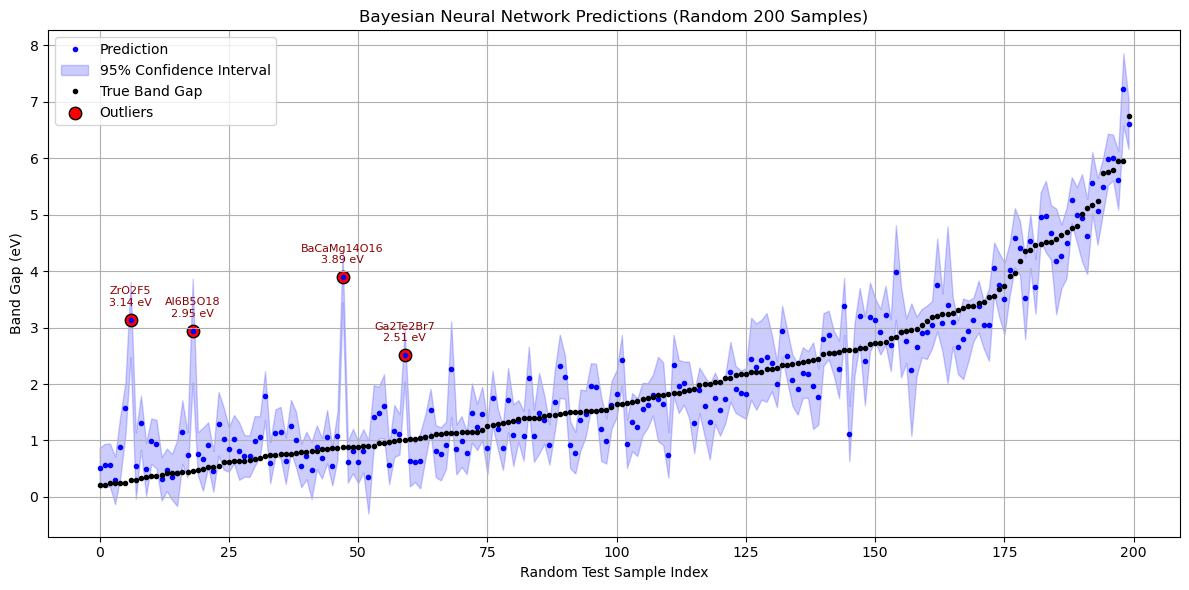

In [34]:
import numpy as np

n_plot = 200
total_points = len(sorted_mean_pred_actual)
np.random.seed(1)  # for reproducibility

# Randomly select 200 unique indices
rand_indices = np.random.choice(total_points, n_plot, replace=False)

# Sort for better visualization (optional)
rand_indices = np.sort(rand_indices)

# Slice arrays
x = np.arange(n_plot)
sorted_mean_pred_actual_ = sorted_mean_pred_actual[rand_indices]
sorted_std_pred_actual_ = sorted_std_pred_actual[rand_indices]
sorted_y_test_actual_ = sorted_y_test_actual[rand_indices]
lower_ = lower[rand_indices]
upper_ = upper[rand_indices]

# Recompute errors and outliers for the subset
errors_ = np.abs(sorted_mean_pred_actual_ - sorted_y_test_actual_)
outlier_mask_ = errors_ > 1.5
outlier_indices_ = np.where(outlier_mask_)[0]
outlier_preds_ = sorted_mean_pred_actual_[outlier_indices_]

# Map random → sorted → test → original index for the subset
sorted_indices_ = sorted_indices[rand_indices]
outlier_test_indices_ = sorted_indices_[outlier_indices_]
outlier_original_indices_ = idx_test[outlier_test_indices_]
formulas_ = df_mp.iloc[outlier_original_indices_]["formula_pretty"].values

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, sorted_mean_pred_actual_, 'b.', label="Prediction")
plt.fill_between(x, lower_, upper_, color='blue', alpha=0.2, label="95% Confidence Interval")
plt.plot(x, sorted_y_test_actual_, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices_], outlier_preds_, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate outliers
for i, idx in enumerate(outlier_indices_):
    pred_val = sorted_mean_pred_actual_[idx]
    formula = formulas_[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

plt.xlabel("Random Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Bayesian Neural Network Predictions (Random 200 Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.savefig('BNN_MCMC_Basic_model_95.png', dpi=300)

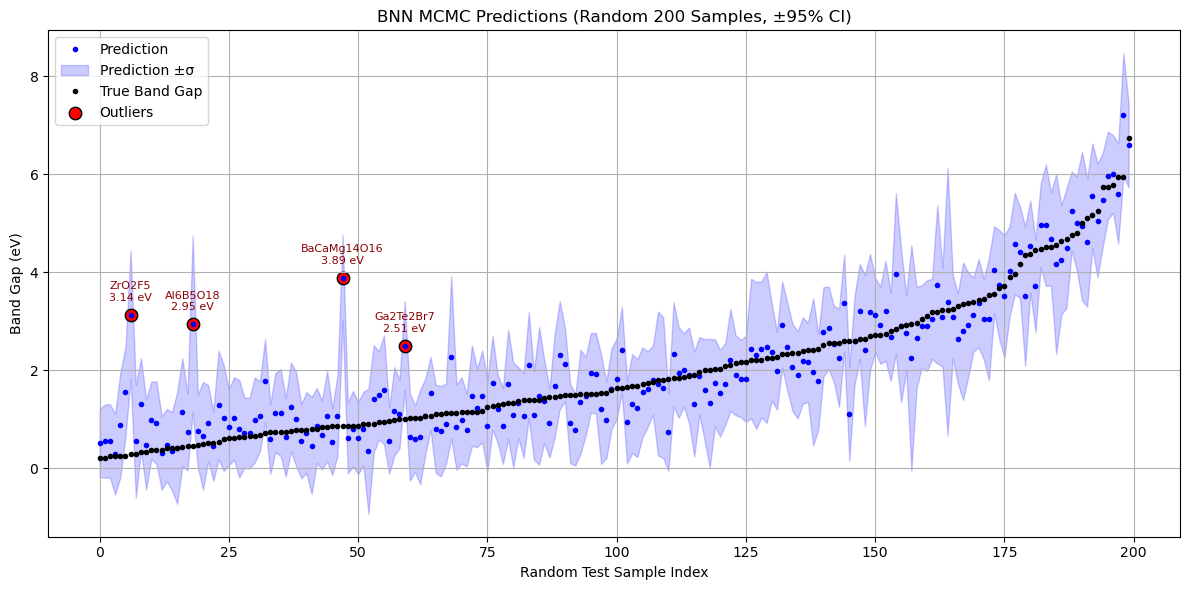

In [35]:
import numpy as np

n_plot = 200
total_points = len(sorted_mean_pred_actual)
np.random.seed(1)  # for reproducibility

# Randomly select 200 unique indices
rand_indices = np.random.choice(total_points, n_plot, replace=False)
rand_indices = np.sort(rand_indices)  # optional: for visualization

# Slice arrays for random samples
x = np.arange(n_plot)
mean_ = sorted_mean_pred_actual[rand_indices]
std_ = sorted_std_pred_actual[rand_indices]
y_true_ = sorted_y_test_actual[rand_indices]
lower_ = mean_ - 1.96* std_
upper_ = mean_ + 1.96* std_

# Outlier detection for the subset
errors_ = np.abs(mean_ - y_true_)
outlier_mask_ = errors_ > 1.5
outlier_indices_ = np.where(outlier_mask_)[0]
outlier_preds_ = mean_[outlier_indices_]

# Map random → sorted → test → original index for the subset
sorted_indices_ = sorted_indices[rand_indices]
outlier_test_indices_ = sorted_indices_[outlier_indices_]
outlier_original_indices_ = idx_test[outlier_test_indices_]
formulas_ = df_mp.iloc[outlier_original_indices_]["formula_pretty"].values

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, mean_, 'b.', label="Prediction")
plt.fill_between(x, lower_, upper_, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, y_true_, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices_], outlier_preds_, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate outliers
for i, idx in enumerate(outlier_indices_):
    pred_val = mean_[idx]
    formula = formulas_[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

plt.xlabel("Random Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN MCMC Predictions (Random 200 Samples, ±95% CI)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.savefig('BNN_MCMC_Basic_model_std.png', dpi=300)

## Consistent plotting for the poster

In [40]:
from sklearn.metrics import r2_score, mean_squared_error

def plot_uncertainty(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Uncertainty Prediction (±σ)", file_name=None
):
    # Compute CI bounds
    lower = y_pred - y_std
    upper = y_pred + y_std

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Begin plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='Prediction ±σ')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers (optional)
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )

    plt.xlabel("Test Sample Index", fontsize=24)
    plt.ylabel("Band Gap (eV)", fontsize=24)
    #plt.title(f"{title}\nR²: {r2:.3f} | MSE: {mse:.3f}", fontsize=16)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()


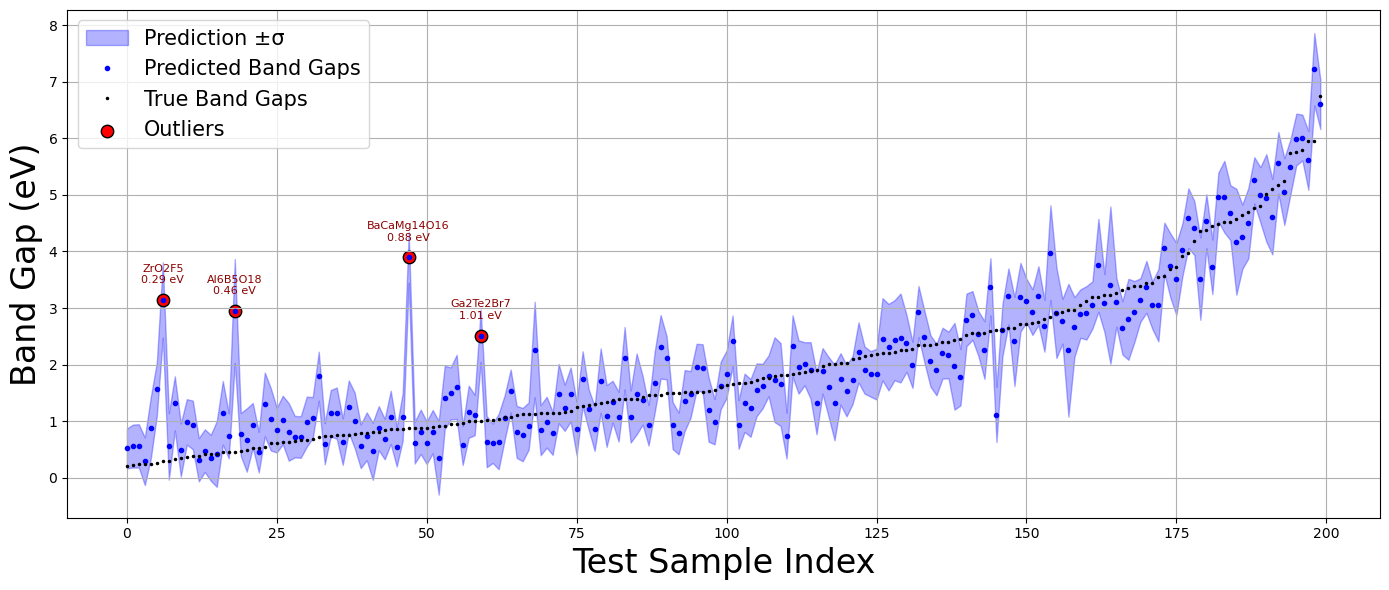

In [41]:
x = np.arange(200)
plot_uncertainty(
    x, y_true_, mean_, std_, outlier_mask_, 
    formulas=formulas_,
    title="BNN MCMC Band Gap Predictions (±σ)",
    file_name="BNN_MCMC_BandGap.png"
)


## Plot 95% CI

In [38]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def plot_95ci(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Prediction with 95% Confidence Interval", file_name=None
):
    # 95% CI bounds assuming normal distribution: ±1.96 * std
    ci_multiplier = 1.96
    lower = y_pred - ci_multiplier * y_std
    upper = y_pred + ci_multiplier * y_std

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='95% Confidence Interval')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )

    plt.xlabel("Test Sample Index")
    plt.ylabel("Band Gap (eV)")
    plt.title(f"{title}\nR²: {r2:.3f} | MSE: {mse:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()


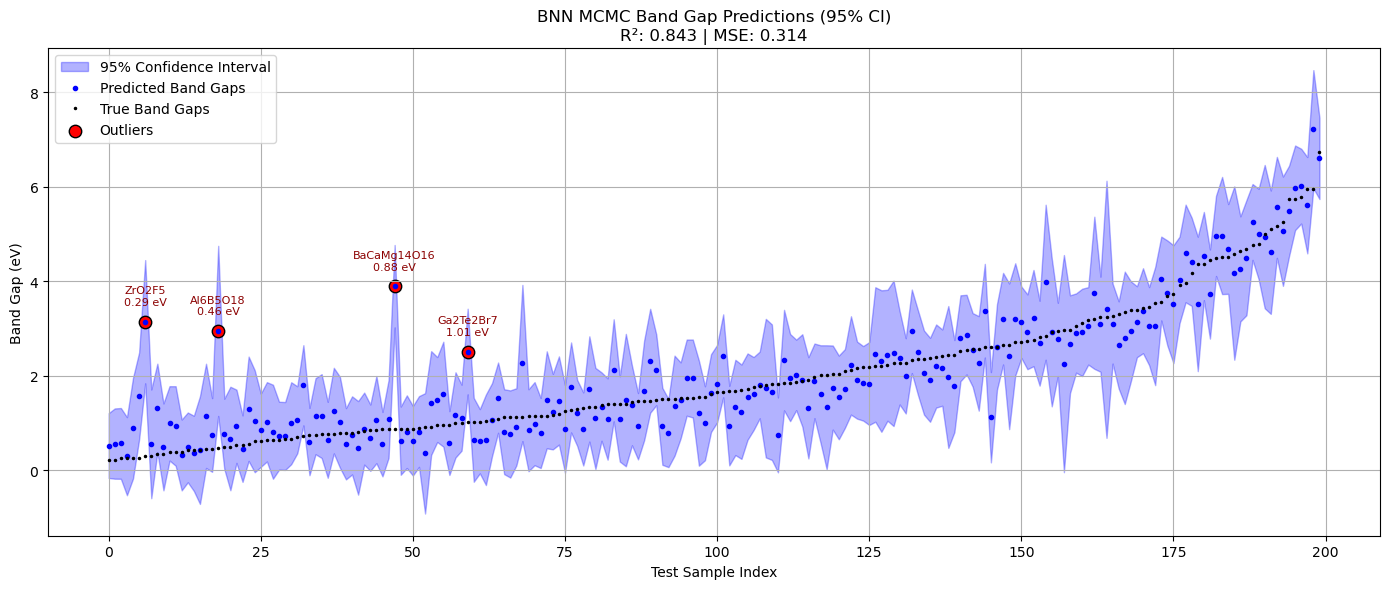

In [39]:
x = np.arange(200)
plot_95ci(
    x, y_true_, mean_, std_, outlier_mask_, 
    formulas=formulas_,
    title="BNN MCMC Band Gap Predictions (95% CI)",
    file_name="BNN_MCMC_BandGap_95.png"
)
